In [247]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import scipy.stats as stats

Define a plotting function for polar stereographic plots.  X is field to plot, max_lat is how far out the plot should zoom, cbar_lims is the limit for the colorbar

In [2]:
def polar_stereo_plot_anom(lon,lat,X,max_lat,cbar_lims,is_anom):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.set_extent([-180,180,max_lat,90],crs=ccrs.PlateCarree())
    if is_anom == True:
        cp = ax.pcolormesh(lon,lat,X,transform=ccrs.PlateCarree(),
                       cmap='seismic',vmin=-cbar_lims,vmax=cbar_lims)
    else:
        cp = ax.pcolormesh(lon,lat,X,transform=ccrs.PlateCarree(),
                          cmap='seismic',vmin=0,vmax=cbar_lims)
    
    cbar = plt.colorbar(cp,pad=0.05,extend='both')
    ax.coastlines()
    return ax, cbar, fig

This function calculates the difference of means for our composites


In [3]:
def diff_of_means(X1,X2,alpha,N1,N2,select_axis):
    sigma_1 = X1.std(axis=select_axis)
    sigma_2 = X2.std(axis=select_axis)
    mu_1 = X1.mean(axis=select_axis)
    mu_2 = X2.mean(axis=select_axis)
    t_denom = (sigma_1**2)/N1 + (sigma_2**2)/N2
    tscore = (mu_2 - mu_1)/np.sqrt(t_denom)
    dof = min(N1,N2)
    tcrit = stats.t.ppf(alpha,dof)
    return tscore, tcrit

Load Z500 for all days in season of interest

In [4]:
model_name = 'ecmwfc3s'
var_name = 'Z500'
seas = 'JJAS'
months = [6,7,8,9]
filepath = '/home/disk/sipn/mcmcgraw/data/atmospheric_data/{model_name}/{variable_name}/'.format(model_name=model_name,
                                                           variable_name=var_name)

filename = xr.open_mfdataset(filepath+'/*.nc',concat_dim='time')
lon = filename.longitude
lon = np.append(lon,lon[0]) #repeat first column for plotting
lat = filename.latitude
z500 = filename.z
z500 = xr.concat([z500,z500.isel(longitude=0)],'longitude') #repeat first longitude for plotting
z500_date = filename.time
z500_date = pd.DatetimeIndex(z500_date.values)

Get only z500 days in <code>months</code>.  We'll keep all gridpoints, all ensembles. Eventually we want to compare the ensemble mean of ALL days in <code>months</code> to the ensemble mean of the VRILE days.

In [5]:
z500_month_ind = np.isin(z500_date.month,months)
z500_seas = z500.sel(time=z500_month_ind)

Now, load z500 for all days that are VRILEs in a given region.  The region corresponds to the ice loss--we will always show the entire Z500 field 

In [6]:
test_path = '/home/disk/sipn/mcmcgraw/data/VRILE/'
region_test = "East-Siberian-Beaufort-Chukchi"

file_test = test_path+'{model_name}_{var_name}_anomalies_VRILE_days_in_{region}_{seas}.nc'.format(model_name=model_name,
                                                                                                 var_name=var_name,
                                                                                                 region=region_test,
                                                                                                 seas=seas)
z500_test = xr.open_dataset(file_test)
z500_test = xr.concat([z500_test,z500_test.isel(longitude=0)],'longitude') #repeat first longitude for plotting
#z500_test
#z = z500_test['z']

Make an ensemble mean of Z500 on <b>all days</b> and <b>VRILE days only</b>.  The VRILE days are already in anomaly form. 

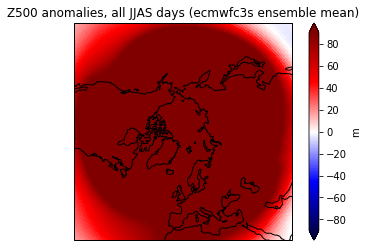

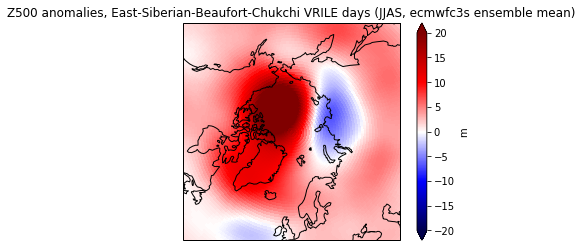

In [211]:
z500_ALL_ens_mean = z500_seas.mean(dim=['number','time']) - z500.mean(dim=['number','time'])
z500_VRILE_ens_mean = z500_test.mean(dim=['number','time'])
#
ax1,cbar1,fig1 = polar_stereo_plot_anom(lon,lat,(1/9.81)*z500_ALL_ens_mean,30,90,True)
ax1.set_title('{var_name} anomalies, all {seas} days ({model_name} ensemble mean)'.format(var_name=var_name,
                                                                           seas=seas,
                                                                           model_name=model_name))
cbar1.ax.set_ylabel('m')
#
ax2,cbar2,fig2 = polar_stereo_plot_anom(lon,lat,(1/9.81)*z500_VRILE_ens_mean['z'].values,50,20,True)
cbar2.ax.set_ylabel('m')
ax2.set_title('{var_name} anomalies, {region} VRILE days ({seas}, {model_name} ensemble mean)'.format(var_name=var_name,
                                                                           region=region_test,seas=seas,
                                                                           model_name=model_name))
fpath_2 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/atmosphere/z500/VRILE_composites/ensemble_means/'
fname_2 = fpath_2+'{var_name}_anoms_ENS_NAME_{region}_VRILE_{seas}_{model_name}.pdf'.format(var_name=var_name,
                                                                                       region=region_test,
                                                                                       seas=seas,
                                                                                       model_name=model_name)
fig2.savefig(fname_2,format='pdf',bbox_inches='tight')

In [222]:
z500_ALL_ens = z500_seas.mean(dim=['number']) - z500.mean(dim=['number'])
z500_VRILE_ens = z500_test.mean(dim=['number'])

In [273]:
N1 = z500_ALL_ens.shape
N1 = N1[0]
N2 = z500_VRILE_ens['z'].shape
N2 = N1*0.05
alpha=0.05
sigma_1 = z500_ALL_ens.std(dim='time')
sigma_2 = z500_VRILE_ens.std(dim='time')
mu_1 = z500_ALL_ens.mean(dim='time')
mu_2 = z500_VRILE_ens.mean(dim='time')
t_denom = (sigma_1**2)/N1 + (sigma_2**2)/N2
tscore = (mu_2 - mu_1)/np.sqrt(t_denom)
dof = min(N1,N2)
tcrit = stats.t.ppf(alpha,dof)

In [320]:
fart = tscore['z'].values


435.59714

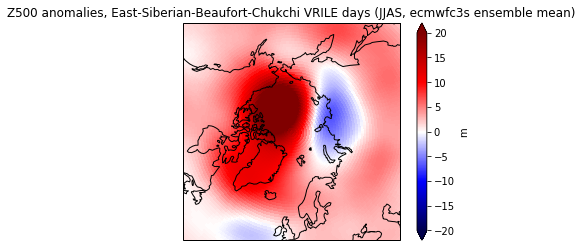

In [298]:
tcrit
#tscore_mask = tscore.where(abs(tscore['z'])>abs(tcrit))
z500_VRILE_ens_mean_SIG = z500_VRILE_ens_mean.where(abs(tscore)>400)
ax5,cbar5,fig5 = polar_stereo_plot_anom(lon,lat,(1/9.81)*z500_VRILE_ens_mean_SIG['z'].values,50,20,True)
cbar5.ax.set_ylabel('m')
ax5.set_title('{var_name} anomalies, {region} VRILE days ({seas}, {model_name} ensemble mean)'.format(var_name=var_name,
                                                                           region=region_test,seas=seas,
                                                                           model_name=model_name))
fpath_5 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/atmosphere/z500/VRILE_composites/ensemble_means/'
fname_5 = fpath_2+'{var_name}_anoms_ENS_NAME_{region}_VRILE_{seas}_{model_name}.pdf'.format(var_name=var_name,
                                                                                       region=region_test,
                                                                                       seas=seas,
                                                                                       model_name=model_name)

In [8]:
z500_time_mean = z500_test.mean(dim='time')
z500_pos = z500_time_mean.where(z500_time_mean>0)
no_pos = z500_pos.count(dim='number')
no_pos
#fart.plot()

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 361)
Coordinates:
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 0.0
Data variables:
    z          (latitude, longitude) int64 25 25 25 25 25 25 ... 17 17 17 17 17

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


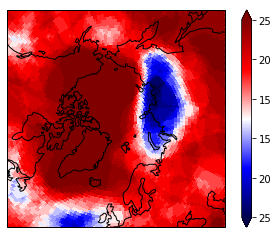

In [9]:
ax3,cbar3,fig3 = polar_stereo_plot_anom(lon,lat,no_pos['z'].values,50,25,False)
cbar3.ax.set_yticks([0,3,6,9,12,15,18,21,24])
cbar3.ax.set_yticklabels([25,20,15,15,20,25])
3
fpath_3 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/atmosphere/z500/VRILE_composites/'
fname_3 = fpath_3+'{var_name}_sign_agreement_{region}_VRILE_{seas}_{model_name}.pdf'.format(var_name=var_name,
                                                                                       region=region_test,
                                                                                       seas=seas,
                                                                                       model_name=model_name)
fig3.savefig(fname_3,format='pdf',bbox_inches='tight')

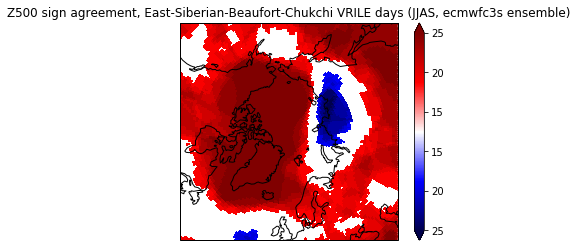

In [10]:
no_pos_mask = no_pos.where((no_pos['z']>=19) | (no_pos['z']<=6))
ax4,cbar4,fig4 = polar_stereo_plot_anom(lon,lat,no_pos_mask['z'].values,50,25,False)
cbar4.ax.set_yticks([0,3,6,9,12,15,18,21,24])
cbar4.ax.set_yticklabels([25,20,15,15,20,25])
ax4.set_title('{var_name} sign agreement, {region} VRILE days ({seas}, {model_name} ensemble)'.format(var_name=var_name,
                                                                           region=region_test,seas=seas,
                                                                           model_name=model_name))
fpath_4 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/atmosphere/z500/VRILE_composites/sig_points_only/'
fname_4 = fpath_4+'{var_name}_sign_agreement_SIG_ONLY_{region}_VRILE_{seas}_{model_name}.pdf'.format(var_name=var_name,
                                                                                       region=region_test,
                                                                                       seas=seas,
                                                                                       model_name=model_name)
fig4.savefig(fname_4,format='pdf',bbox_inches='tight')

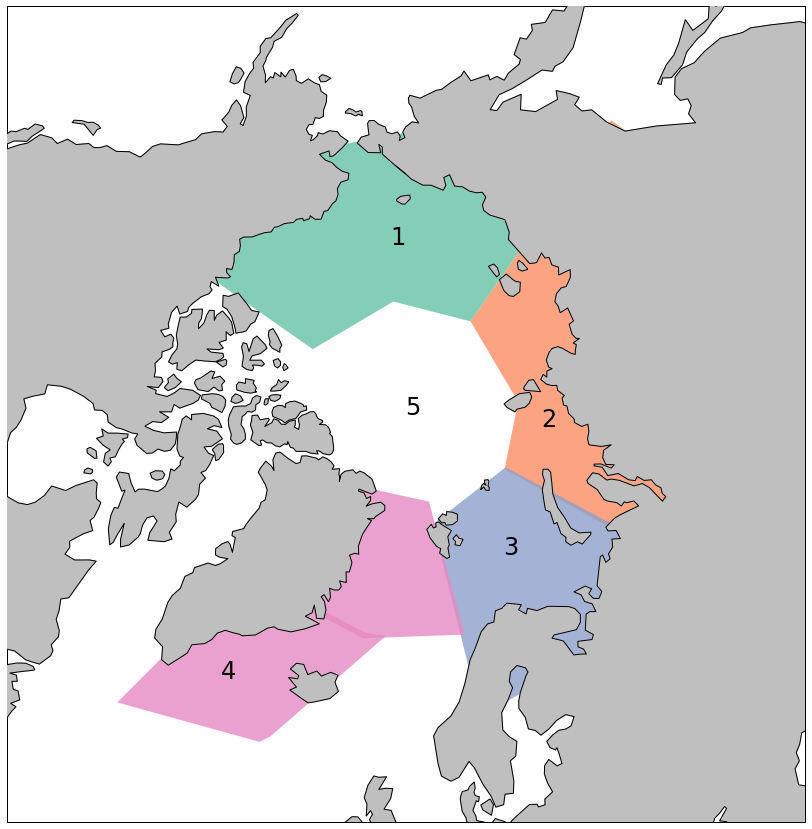

In [210]:
import matplotlib.patches as mpatches
fig8 = plt.figure(figsize=(30,15))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
ax.set_extent([-180,180,55,90],crs=ccrs.PlateCarree())
ax.add_patch(mpatches.Rectangle(xy=[145, 65], width=90, height=15,
                                    facecolor='#66c2a5',
                                    alpha=0.8,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[61, 59], width=84, height=21,
                                    facecolor='#fc8d62',
                                    alpha=0.8,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[14, 63], width=48, height=17,
                                    facecolor='#8da0cb',
                                    alpha=0.8,
                                    transform=ccrs.PlateCarree()))
ax.add_patch(mpatches.Rectangle(xy=[-45, 70], width=60, height=12,
                                    facecolor='#e78ac3',
                                    alpha=0.8,
                                    transform=ccrs.PlateCarree()))
verts2 = [(-45,55),(-45,70.5),(-5,70.5),(-24,59)]
ax.add_patch(mpatches.Polygon(verts2,
                                    facecolor='#e78ac3',
                                    alpha=0.8,
                                    transform=ccrs.PlateCarree()))

ax.coastlines(zorder=9)
ax.add_feature(cartopy.feature.LAND, facecolor='0.75',zorder=8)
plt.text(-175,75,'1',transform=ccrs.Geodetic(),fontsize=24,zorder=9)
plt.text(85,78,'2',transform=ccrs.Geodetic(),fontsize=24,zorder=9)
plt.text(35,75,'3',transform=ccrs.Geodetic(),fontsize=24,zorder=9)
plt.text(-35,62,'4',transform=ccrs.Geodetic(),fontsize=24,zorder=9)
plt.text(-75,90,'5',transform=ccrs.Geodetic(),fontsize=24,zorder=9)
fname_8 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/REGIONS_MAP_POSTER.pdf'
fig8.savefig(fname_8,format='pdf',bbox_inches='tight')

In [82]:
beauf_lats = np.transpose([65.37,80.00,77.69,75.67,65.00])
beauf_lons = np.transpose([-156.65,-156.48,-112.34,-124.58,-124.00])

vertices = [beauf_lons,beauf_lats]
#ax.add_patch(mpatches.Polygon(xy=vertices))

(5, 2)

In [91]:
grid = np.mgrid[0.2:0.8:3j, 0.2:0.8:3j].reshape(2, -1).T
grid[3]

array([0.5, 0.2])

[(2, 0),
 (2.0, 70.0),
 (2.142857142857143, 73.10495626822157),
 (2.2857142857142856, 75.8600583090379),
 (2.4285714285714284, 78.28279883381924),
 (2.571428571428571, 80.39067055393586),
 (2.7142857142857144, 82.20116618075802),
 (2.857142857142857, 83.73177842565597),
 (3.0, 85.0),
 (3.142857142857143, 86.02332361516035),
 (3.2857142857142856, 86.8192419825073),
 (3.4285714285714284, 87.40524781341108),
 (3.571428571428571, 87.79883381924198),
 (3.7142857142857144, 88.01749271137027),
 (3.8571428571428568, 88.07871720116619),
 (4.0, 88.0),
 (4.142857142857142, 87.79883381924198),
 (4.285714285714286, 87.49271137026238),
 (4.428571428571429, 87.09912536443149),
 (4.571428571428571, 86.63556851311954),
 (4.7142857142857135, 86.1195335276968),
 (4.857142857142857, 85.56851311953353),
 (5.0, 85.0),
 (5.142857142857142, 84.43148688046648),
 (5.285714285714286, 83.88046647230321),
 (5.428571428571429, 83.36443148688046),
 (5.571428571428571, 82.90087463556851),
 (5.7142857142857135, 82.507

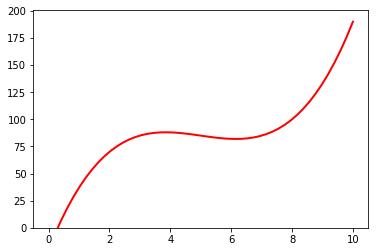

In [110]:
def func(x):
    return (x - 3) * (x - 5) * (x - 7) + 85

a, b = 2, 9  # integral limits
x = np.linspace(0, 10)
y = func(x)

fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
verts2 = [(-45,57),(-45,65),(-10,65)]


Z500 plots to make:<br>
   <li> Ensemble mean<br>
   <li> Sign agreement<br>
   <li> For each: all vs significant <br>
<br>    
SIE only plots to make:<br>
   <li> Distribution: 5th pctile threshold for each ensemble member + obs<br>
   <li> On how many days does modeled SIE drop below observed 5th pctile? <br>
   <li> Line plots vs chiclet plot <br>
   <li> Same for 95th percentile<br>
<br>
Skewness<br>
    <li> Modeled skewness:<br>
        <li> Skewness of each ensemble member by month / season <br>
        <li> Skewness of ensemble mean by month / season <br>
     <li> Compare distribution of model skewnesses to observed skewness (by month / season) <br>
     <li> This can be a box plot <br>
    
    

In [27]:
import scipy.stats as stats
fart = stats.binom_test(19,25,0.5)


6